In [2]:
import pandas as pd
import numpy as np
import datetime
import warnings

warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")


import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE 
from imblearn.under_sampling import TomekLinks
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from collections import Counter
from sklearn.datasets import make_classification

from numpy import where

import scipy.stats as stats
from scipy.special import inv_boxcox   
import os #we will use the function listdir to list files in a folder
import math
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, acf, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf,month_plot,quarter_plot
from scipy import signal
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

%matplotlib inline

pd.set_option('display.max_columns', None)

# Data Wrangling

## Importing Data

In [3]:
data = pd.read_csv('creditcardmarketing.csv', header=None)

In [4]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0
3,4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0,419.0
4,5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0,365.0


### Renaming and Choosing the Index
First, let's rename the columns to make the exploration more efficient
We'll also set the id as the index

In [5]:
column_names = ['Customer Number', 'Offer Accepted', 'Reward', 'Mailer Type', 'Income Level', 'Bank Accounts Open', 'Overdraft Protection', 'Credit Rating', 'Credit Cards Held', 'Homes Owned', 'Household Size', 'Own Your Home', 'Average Balance', 'Q1 Balance', 'Q2 Balance', 'Q3 Balance', 'Q4 Balance']

In [6]:
def rename_columns(df):
    for i in range(0, df.shape[1]):
        df.rename(columns={df.columns[i]: column_names[i]}, inplace=True)
    data.columns = data.columns.str.lower().str.replace(" ", "_")
    return df

In [7]:
data = rename_columns(data)
data = data.set_index('customer_number')
data.head()

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
customer_number,,,,,,,,,,,,,,,,
1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0
4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0,419.0
5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0,365.0


## Exploring the Data
We will check the data types, unique values, null values and statistical overview of the data

### Data overview

In [8]:
data.shape

(18000, 16)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18000 entries, 1 to 18000
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   offer_accepted        18000 non-null  object 
 1   reward                18000 non-null  object 
 2   mailer_type           18000 non-null  object 
 3   income_level          18000 non-null  object 
 4   bank_accounts_open    18000 non-null  int64  
 5   overdraft_protection  18000 non-null  object 
 6   credit_rating         18000 non-null  object 
 7   credit_cards_held     18000 non-null  int64  
 8   homes_owned           18000 non-null  int64  
 9   household_size        18000 non-null  int64  
 10  own_your_home         18000 non-null  object 
 11  average_balance       17976 non-null  float64
 12  q1_balance            17976 non-null  float64
 13  q2_balance            17976 non-null  float64
 14  q3_balance            17976 non-null  float64
 15  q4_balance         

In [10]:
data.describe()

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
count,18000.000000,18000.000000,18000.000000,18000.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000
mean,1.255778,1.903500,1.203444,3.499056,940.515562,910.450656,999.392190,1042.033600,810.185803
std,0.472501,0.797009,0.427341,1.114182,350.297837,620.077060,457.402268,553.452599,559.001365
min,1.000000,1.000000,1.000000,1.000000,48.250000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,3.000000,787.500000,392.750000,663.000000,633.000000,363.000000
50%,1.000000,2.000000,1.000000,3.000000,1007.000000,772.000000,1032.000000,945.500000,703.000000
75%,1.000000,2.000000,1.000000,4.000000,1153.250000,1521.000000,1342.000000,1463.000000,1212.000000
max,3.000000,4.000000,3.000000,9.000000,3366.250000,3450.000000,3421.000000,3823.000000,4215.000000


In [11]:
max(data.average_balance)/4*2+max(data.average_balance)/4

2524.6875

#### Checking for NaN values

In [12]:
def check_nan(df):
    nulls = pd.DataFrame((df.isna().sum()/len(df))*100)
    nulls= nulls.reset_index()
    nulls.columns = ['column_name', 'Percentage Null Values']
    nulls.sort_values(by='Percentage Null Values', ascending = False)
    return nulls

In [13]:
nulls = check_nan(data)
nulls

,column_name,Percentage Null Values
0,offer_accepted,0.000000
1,reward,0.000000
2,mailer_type,0.000000
3,income_level,0.000000
4,bank_accounts_open,0.000000
5,overdraft_protection,0.000000
6,credit_rating,0.000000
7,credit_cards_held,0.000000
8,homes_owned,0.000000
9,household_size,0.000000


In [14]:
data['average_balance'].isna().sum()

24

###### Observation:
The nulls represent very little percentage of the total data (less than 0.15%), so we will most likely drop them later.

### Reviewing the value counts

In [15]:
def check_count(df):
    value_counts = []
    for column in df.columns:
        x = len(df[column].value_counts())
        value_counts.append(x)
    counts = pd.DataFrame(value_counts)
    counts = counts.reset_index()
    counts.columns = ['name', 'value_counts']
    for i in range(0, df.shape[1]):
        counts['name'] = counts['name'].replace(i,df.columns[i])
    return counts

In [16]:
counts = check_count(data)
counts

,name,value_counts
0,offer_accepted,2
1,reward,3
2,mailer_type,2
3,income_level,3
4,bank_accounts_open,3
5,overdraft_protection,2
6,credit_rating,3
7,credit_cards_held,4
8,homes_owned,3
9,household_size,8


##### Checking the indivual value counts  as well as the unique values for columns that have less than thousands of unique value counts

In [17]:
def check_unique_values(df):
    for column in df:
        n = len(df[column].value_counts())
        if n < 10:
            unique = list(df[column].unique())
            values = list(df[column].value_counts())
            value_dict = print(column, ' : ', dict(zip(unique, values)), '\n')
    return value_dict

In [18]:
values = check_unique_values(data)
values

offer_accepted  :  {'No': 16977, 'Yes': 1023} 

reward  :  {'Air Miles': 6061, 'Cash Back': 5999, 'Points': 5940} 

mailer_type  :  {'Letter': 9147, 'Postcard': 8853} 

income_level  :  {'High': 9013, 'Medium': 4526, 'Low': 4461} 

bank_accounts_open  :  {1: 13692, 2: 4012, 3: 296} 

overdraft_protection  :  {'No': 15322, 'Yes': 2678} 

credit_rating  :  {'High': 6071, 'Medium': 5972, 'Low': 5957} 

credit_cards_held  :  {2: 7944, 1: 6154, 3: 3387, 4: 515} 

homes_owned  :  {1: 14523, 2: 3292, 3: 185} 

household_size  :  {4: 5712, 5: 5543, 2: 2853, 6: 2813, 3: 539, 1: 538, 8: 1, 9: 1} 

own_your_home  :  {'No': 11655, 'Yes': 6345} 



### First observations
Most of the data is numerical. We have both continuous and discrete numerical variables. \
The discrete numerical variables represent an ordered range to represent quantitative (ex: Homes owned) or qualitative data (ex: Household Size). 

If we take a look at 'Household Size', we see that there are 9 unique values, two of which (`8` and `9`) have only 1 count. \
We could therefore make the decision to replace them with another value that is more represented. \

For now we keep the value `3` of 'Homes Owned' as it still represents more than 1% of the data.

As for the target, we will have to correct the imbalanced data as the number of `No` supersedes the number of `Yes`.

## Data pre-processing

### Data cleaning

#### First we drop the NaNs that represent less than 0.002% of the data

In [19]:
data = data.dropna()

#### Cleaning household_size
We will replace 8 & 9 because they each have only one count, which accounts for way less than 1% of the total data length. \
As we are dealing with ordinal data, we will replace 8 & 9 with the third highest on the ladder.

In [20]:
count_size = pd.DataFrame(data['household_size'].value_counts())
count_size = count_size.reset_index()
count_size.columns = ['sizes', 'counts']
other_df = count_size[count_size['counts']<(len(data)*0.01)]
other_df = list(other_df['sizes'])
other_df

[8, 9]

In [21]:
def clean_household_size(x):
    if x in other_df:
        return 6
    else:
        return x

data['household_size'] = list(map(clean_household_size, data['household_size']))
data.household_size.value_counts()

3    5705
4    5532
5    2851
2    2809
6     540
1     539
Name: household_size, dtype: int64

### Preparing dataframes and target data for EDA

We separate the categoricals and numerical variables, as well as the discrete and the continuous numerical variables, into different dataframes to see their distributions.

We will also separate the target variable and transform it into a binary numerical data so that we can use it in numerical plots.

In [22]:
numericals = data.select_dtypes(np.number)
numericals.head()

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
customer_number,,,,,,,,,
1,1,2,1,4,1160.75,1669.0,877.0,1095.0,1002.0
2,1,2,2,5,147.25,39.0,106.0,78.0,366.0
3,2,2,1,2,276.50,367.0,352.0,145.0,242.0
4,2,1,1,4,1219.00,1578.0,1760.0,1119.0,419.0
5,1,2,1,6,1211.00,2140.0,1357.0,982.0,365.0


In [23]:
categoricals = data.select_dtypes(np.object)
categoricals.head()

,offer_accepted,reward,mailer_type,income_level,overdraft_protection,credit_rating,own_your_home
customer_number,,,,,,,
1,No,Air Miles,Letter,High,No,High,No
2,No,Air Miles,Letter,Medium,No,Medium,Yes
3,No,Air Miles,Postcard,High,No,Medium,Yes
4,No,Air Miles,Letter,Medium,No,High,No
5,No,Air Miles,Letter,Medium,No,Medium,Yes


In [24]:
def separate_numericals(df):
    for col in df.columns:
        if df[col].dtypes == 'int64':
            df1 = df.select_dtypes(include='int64')
            discrete = df1.to_dict()
            discrete_df = pd.DataFrame.from_dict(discrete)
        else:
            df2 = df.select_dtypes(include='float64')
            continuous = df2.to_dict()
            continuous_df = pd.DataFrame.from_dict(continuous)
    return continuous_df, discrete_df

In [25]:
continuous_df, discrete_df = separate_numericals(numericals)
continuous_df.head()

,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
1,1160.75,1669.0,877.0,1095.0,1002.0
2,147.25,39.0,106.0,78.0,366.0
3,276.50,367.0,352.0,145.0,242.0
4,1219.00,1578.0,1760.0,1119.0,419.0
5,1211.00,2140.0,1357.0,982.0,365.0


In [26]:
discrete_df.head()

,bank_accounts_open,credit_cards_held,homes_owned,household_size
1,1,2,1,4
2,1,2,2,5
3,2,2,1,2
4,2,1,1,4
5,1,2,1,6


In [27]:
target = data[['offer_accepted']]
target['offer_accepted'] = target['offer_accepted'].map(dict(Yes=1, No=0))
target.head()

,offer_accepted
customer_number,
1,0
2,0
3,0
4,0
5,0


## Exploratory Data Analysis

We will run different series of plots for each type of data: continuous numerical, discrete numerical and categorical.

### Plotting the continuous data

#### Density plots

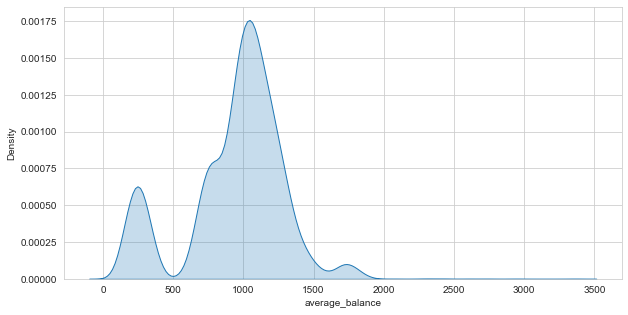

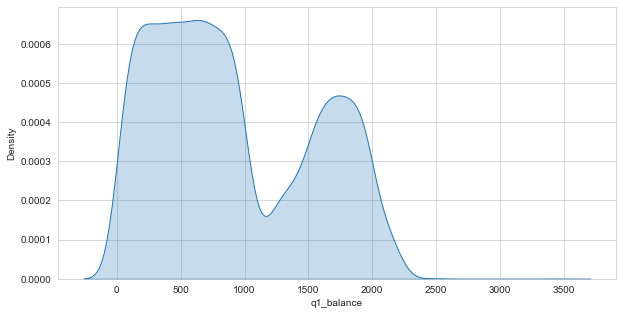

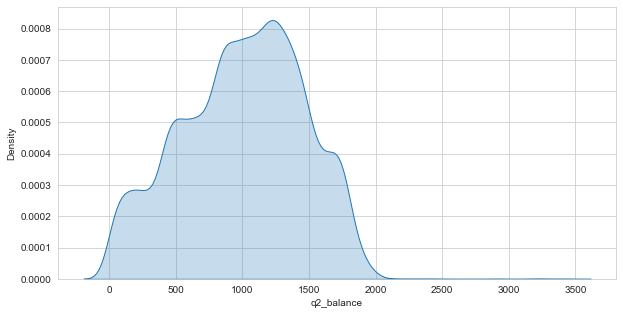

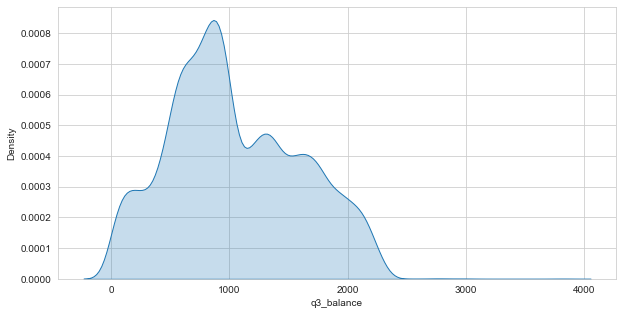

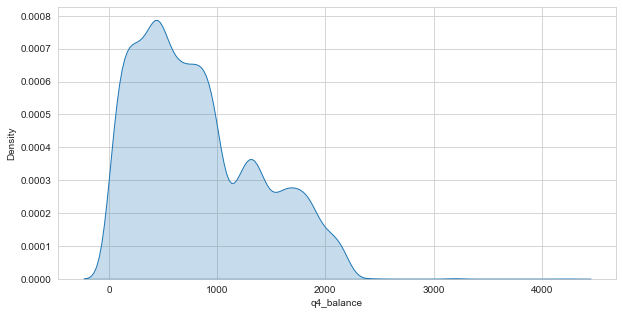

In [28]:
def check_dist(df):
    for column in df:    
        plt.figure(figsize=(10,5))
        plt.xlabel(column)
        plt.ylabel('Density')
        sns.kdeplot(df[column],shade=True)
        plt.show()
    return plt.show()
continuous_dist = check_dist(continuous_df)

#### Scatterplots
Quarters vs. Average balance

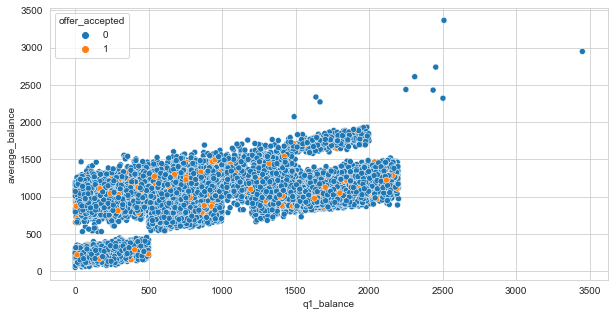

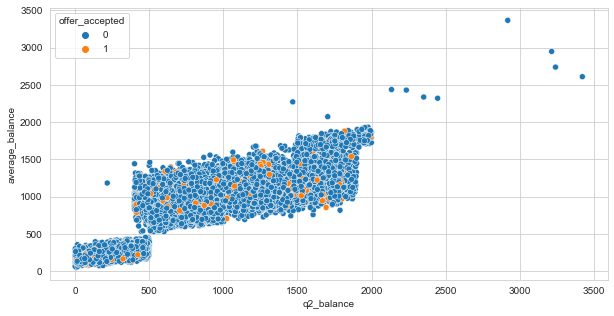

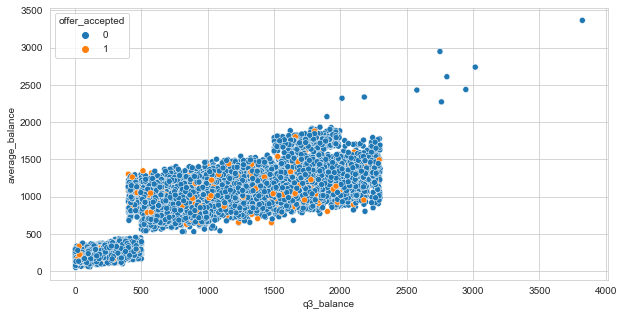

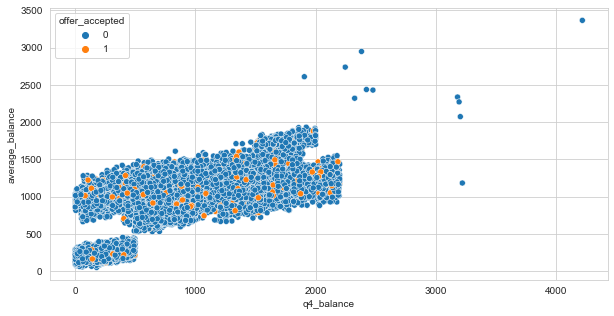

In [29]:
cols_to_include = continuous_df.loc[:, continuous_df.columns != 'average_balance']
for column in cols_to_include:
    plt.figure(figsize=(10,5))
    sns.scatterplot(cols_to_include[column], continuous_df['average_balance'], hue=target['offer_accepted'])
    plt.show()

#### Boxen Plots
Let's take a look at the outliers.
We will use boxenplots instead of boxplots for this dataset, as it fits big dataset (n > 10,000) better than boxplots.

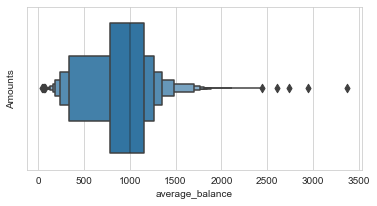

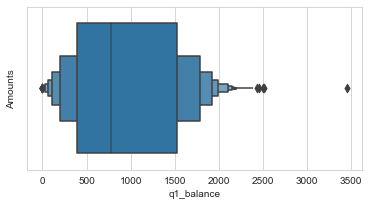

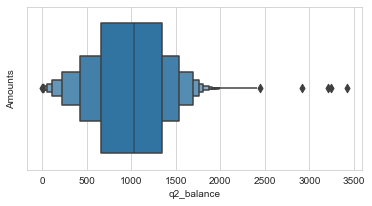

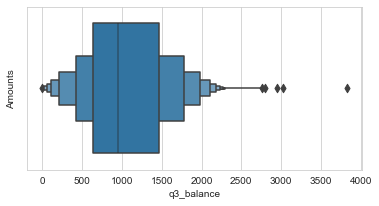

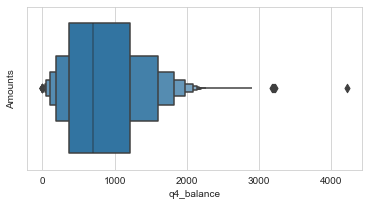

In [30]:
for column in continuous_df:      
    plt.figure(figsize=(6,3))
    plt.ylabel('Amounts')
    sns.boxenplot(x=continuous_df[column])
    plt.show()

#### Correlation matrix
We want to check for colinearity between the continuous exogenous data and see which variables are more correlated to the target variable.

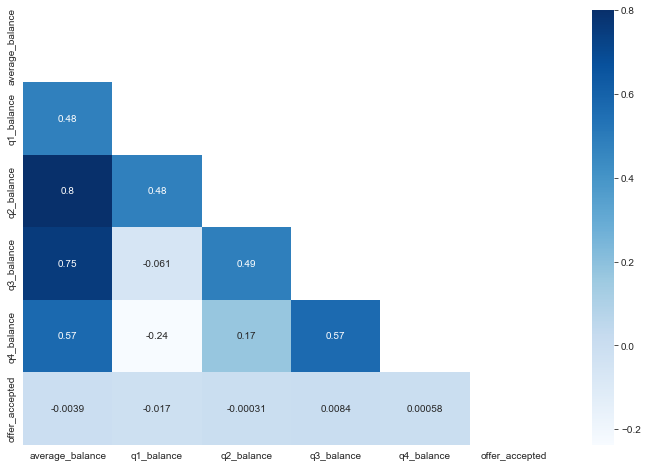

In [31]:
df1 = pd.concat([continuous_df, target], axis=1)
mask = np.zeros_like(df1.corr())
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(12, 8))
ax = sns.heatmap(df1.corr(), mask=mask, annot=True, cmap='Blues')
plt.show()

### Observations
1. Distributions:
    - Average Balance almost follows a normal distributions, the outliers hover around Q1.
    - Q1 Balance does not follow at all a normal distribution. \
      From the correlation matrix, we also remark that it is set apart from the other quarters. \
      It actually looks like two normal distributions merged together, which could attest to the unique financial nature of the first month of the year.
    - Q2 Balance has a distribution that is very similar to a normal one, albeit with a small number of outliers that strecth the distribution towards the lowest balance amounts.
    - Q3 Balance has a distribtion that resembles the one of Q2 balance, but it is more skewed towards the higher balance amounts.
    - Q4 Balance is much more centered on the lowest balance amounts and also skews towards the higher balance amounts. 
         
<br>

2. Outliers:
    - Average Balance contains the most number of outliers out of all the continuous data, which is logical considering it collates four financial quarters that each has its own characteristics.
    - Q1 has the least number of outliers, followed by Q4.
    - Q2 & Q3 have the second most number of outliers after Average Balance.
    
<br> 

3. Correlation:
    - Average Balance, Q2 Balance and Q3 Balance have the highest correlation between them, but are not correlated enough to be collinear (<0.95).
    - Q4 Balance is more correlated with Q3 Balance (EOY similarities) and Average Balance.
    - Q1 Balance is more correlated with Q2 Balance (begining of year similarities) and Average Balance, and is negatively correlated to all of the other balance values.
    - The correlations of the balance variables with the target variable tend towards 0. Average Balance, Q1 Balance and Q2 Balance are negatively correlated with the target variable.    

### Plotting the discrete data

#### Count plots

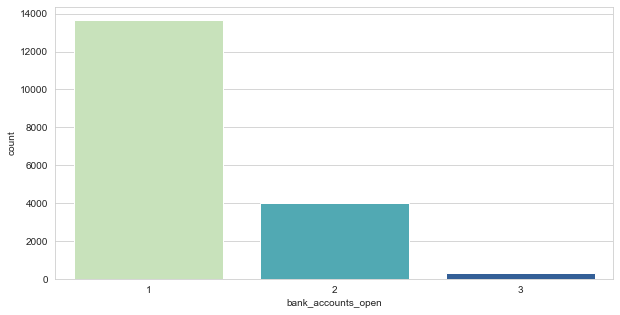

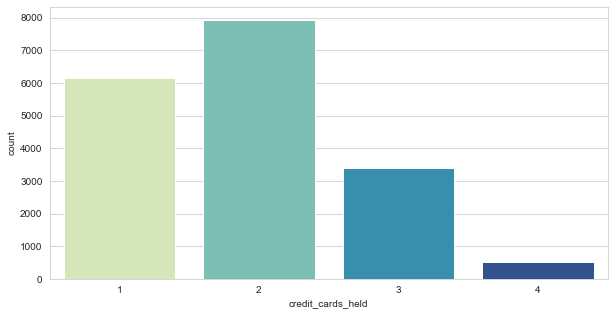

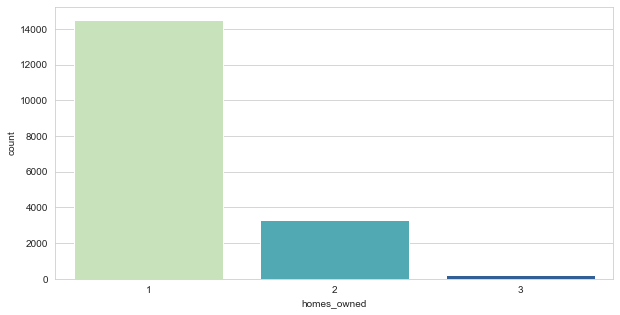

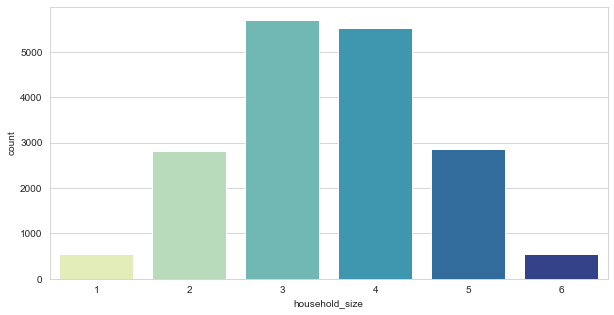

In [32]:
for column in discrete_df:
    plt.figure(figsize=(10,5))
    sns.countplot(x=column, data=discrete_df, palette='YlGnBu')
    plt.show()

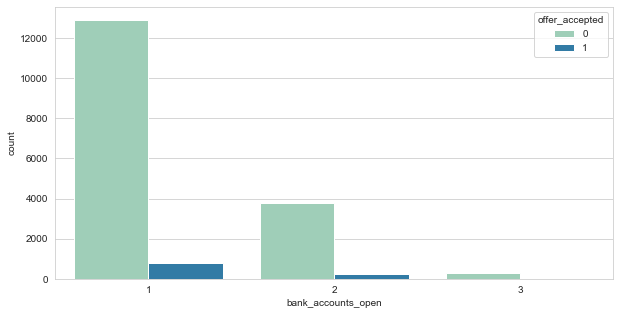

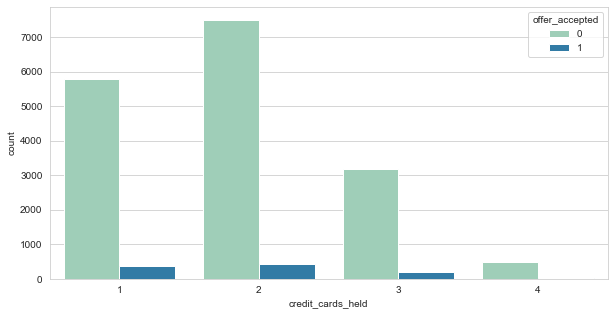

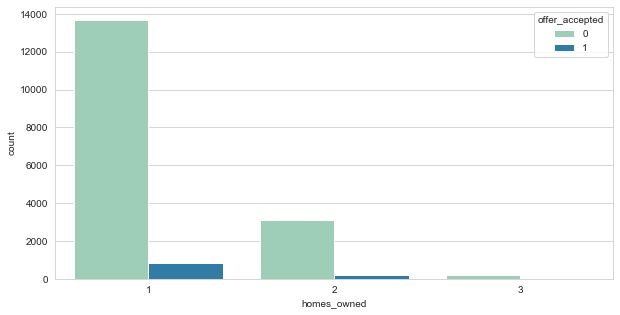

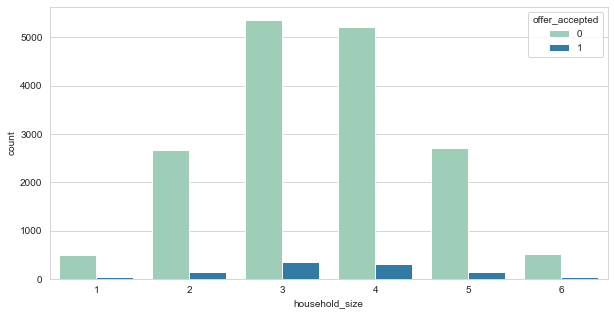

In [33]:
for column in discrete_df:
    plt.figure(figsize=(10,5))
    sns.countplot(x=column, data=discrete_df, hue=target['offer_accepted'], palette='YlGnBu')
    plt.show()

#### Crosstabs

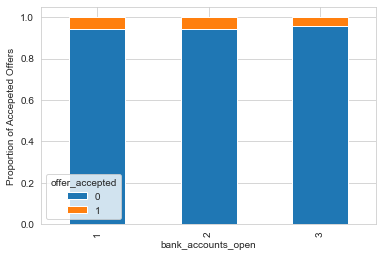

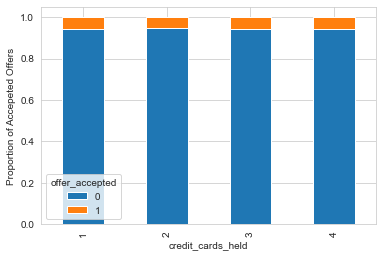

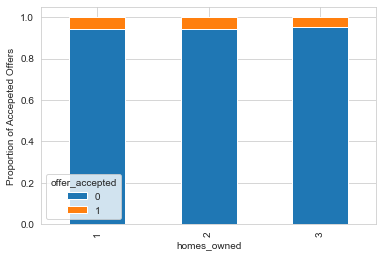

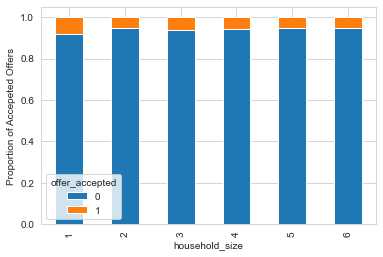

In [34]:
for column in discrete_df:
    table=pd.crosstab(discrete_df[column], target['offer_accepted'])
    table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
    plt.xlabel(column)
    plt.ylabel('Proportion of Accepeted Offers')

#### Correlation matrix
We want to check for colinearity between the discrete exogenous data and see which variables are more correlated to the target variable.

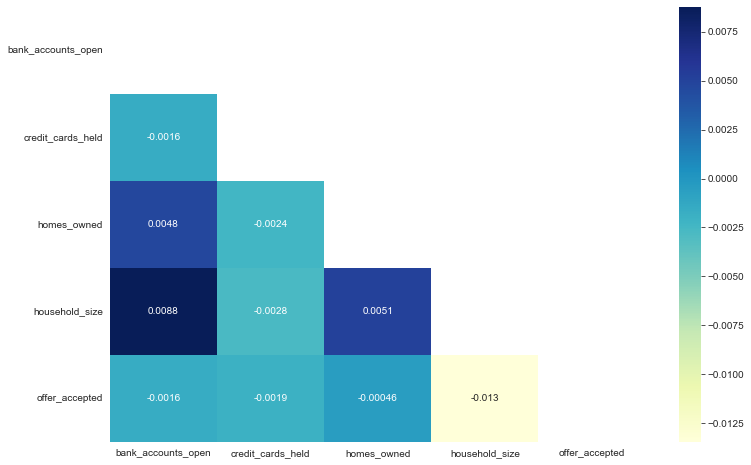

In [35]:
df2 = pd.concat([discrete_df, target], axis=1)
mask2 = np.zeros_like(df2.corr())
mask2[np.triu_indices_from(mask2)] = True
fig2, ax2 = plt.subplots(figsize=(12, 8))
ax2 = sns.heatmap(df2.corr(), mask=mask2, annot=True, cmap='YlGnBu')
plt.show()

### Observations
1. Distributions:
    - Household size is the only variable that follows a normal distribution, which is not surprising considering most of the discrete numerical variables are ordered, so it's natural that one end of the scale is less represented that the other.
 
 
<br>

2. `Yes` repartition:
    - From the countplots, it looks like none of the customer with 3 bank accounts open and/or 4 credit cards held, and/or 3 homes owned have accepted the offer. However, the crosstabs show that it only represents less data compared to the other values.
    
    
<br> 

3. Correlation:
    - All of the variables have little correlation between each other.
    - The highest correlation is a negative one, between household size and offer accepted (1.3%).
    - All of the discrete variables are negatively correlated with the target.

### Plotting the categorical data

#### Countplots

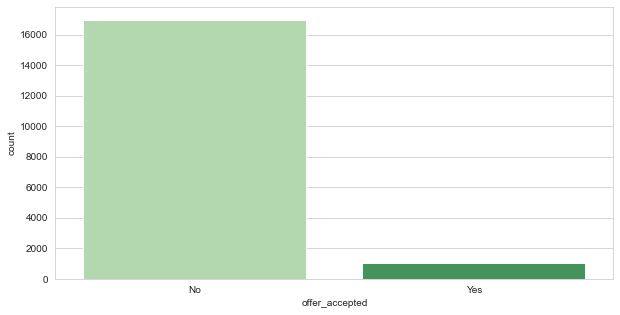

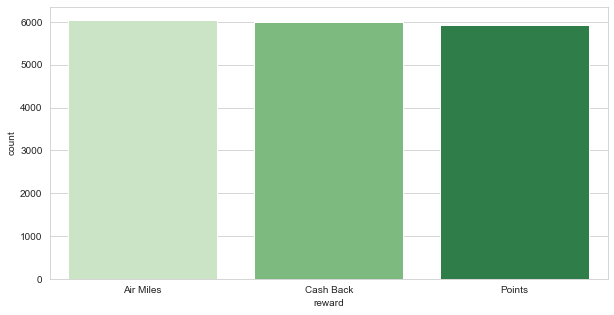

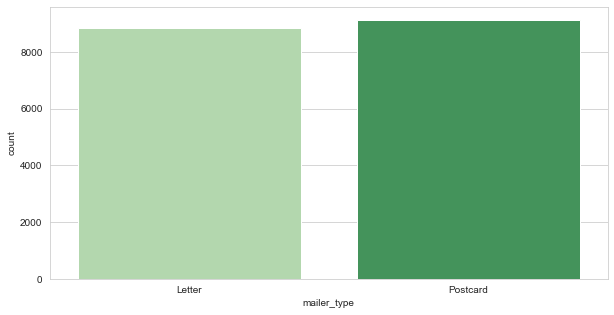

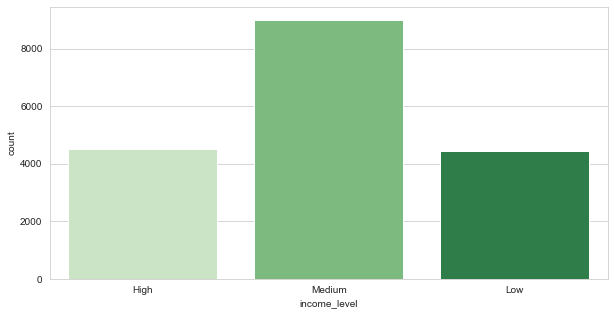

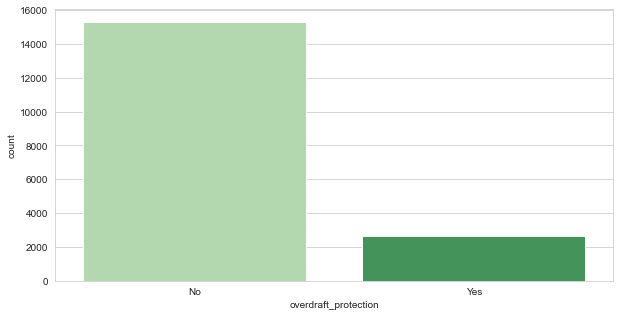

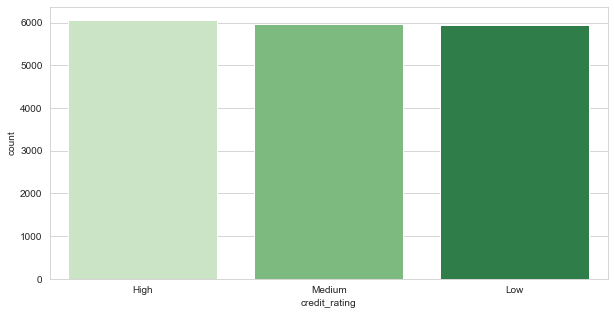

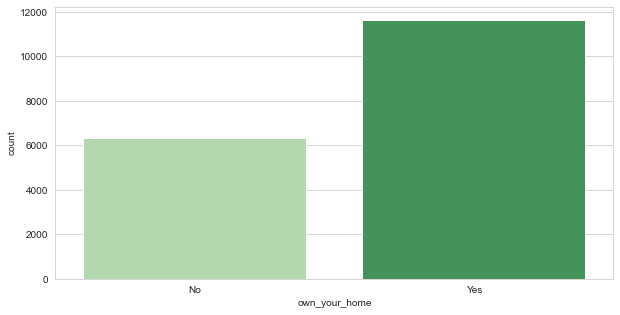

In [36]:
for column in categoricals:
    plt.figure(figsize=(10,5))
    sns.countplot(x=column, data=categoricals, palette='Greens')
    plt.show()

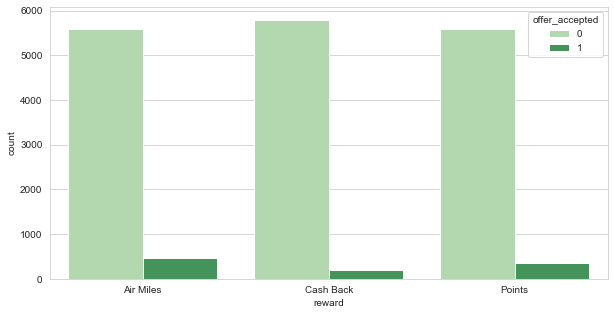

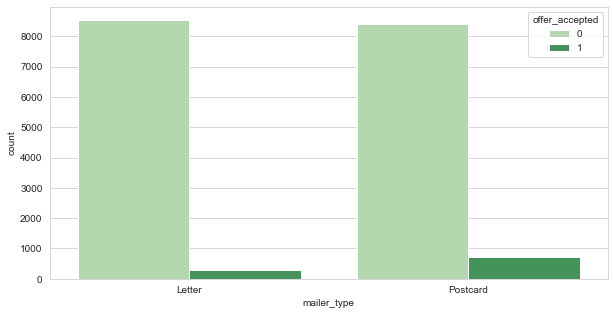

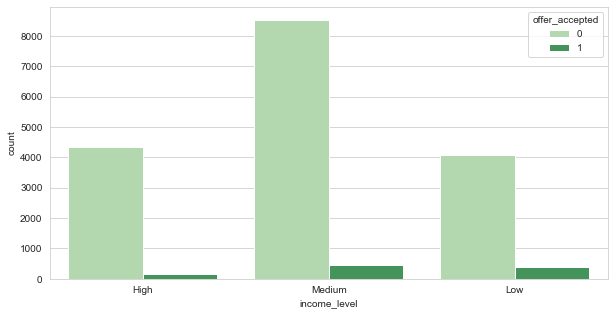

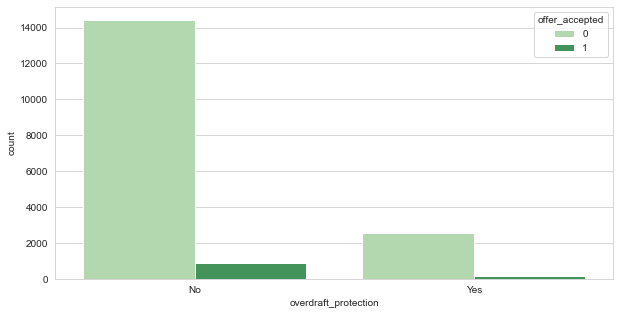

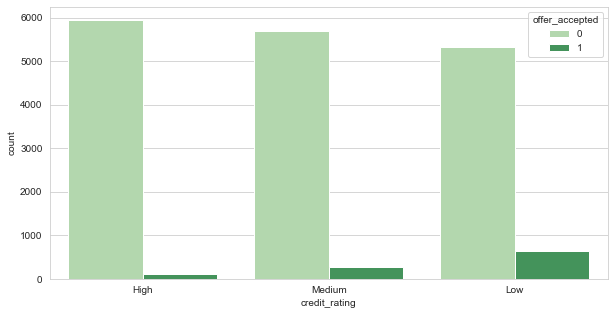

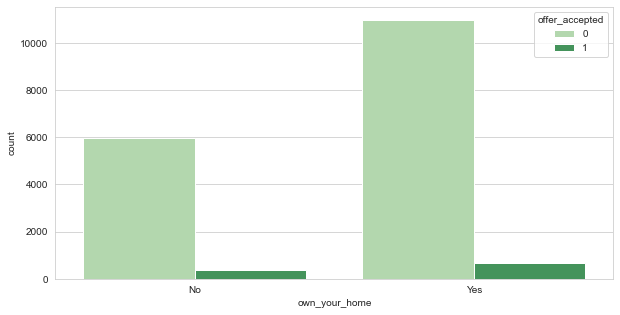

In [37]:
cats_to_include = categoricals.loc[:, categoricals.columns != 'offer_accepted']
for column in cats_to_include:
    plt.figure(figsize=(10,5))
    sns.countplot(x=column, data=cats_to_include, hue=target['offer_accepted'], palette='Greens')
    plt.show()

#### Violin plots

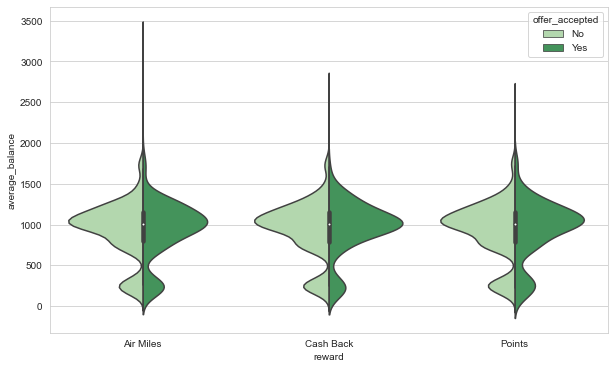

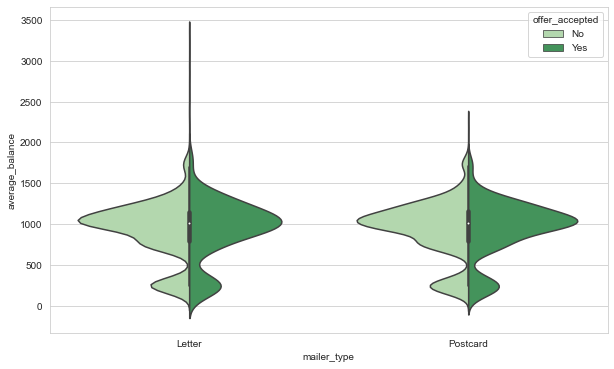

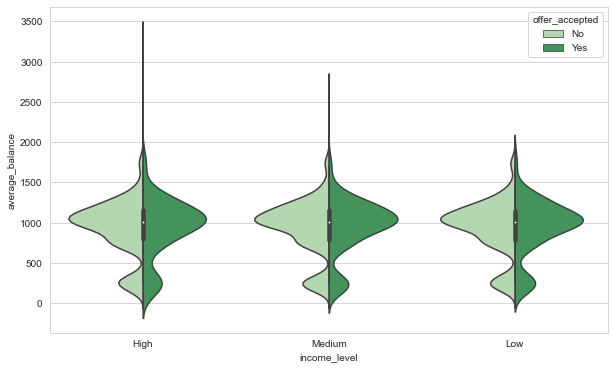

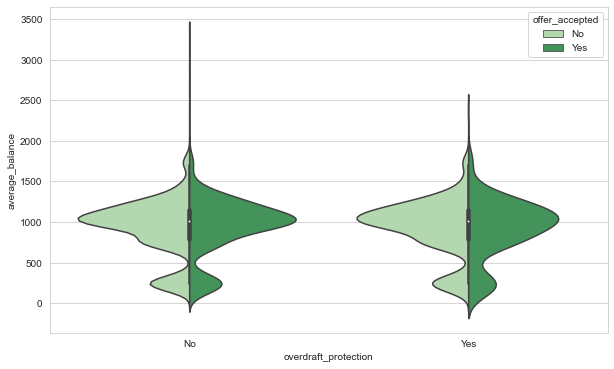

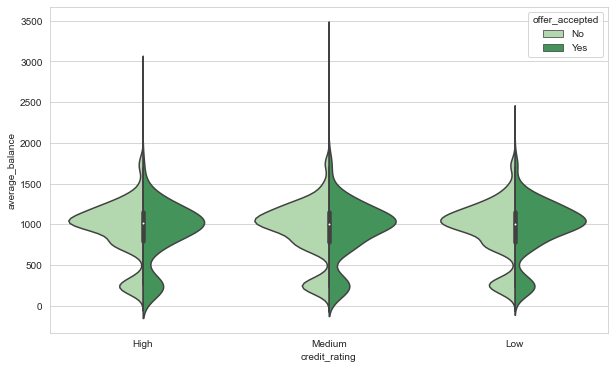

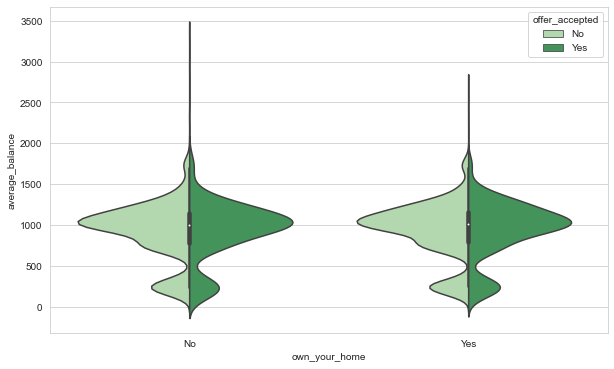

In [38]:
for column in cats_to_include:
    plt.figure(figsize=(10,6))
    sns.violinplot(x=column, y=continuous_df['average_balance'], data=cats_to_include, hue=categoricals['offer_accepted'], split='True', palette='Greens')
    plt.show

##### Boxen Plots
Let's take a look at the distribution of average balance by each categorical data.

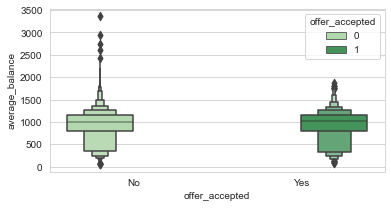

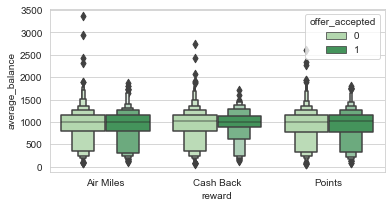

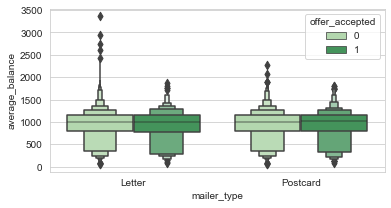

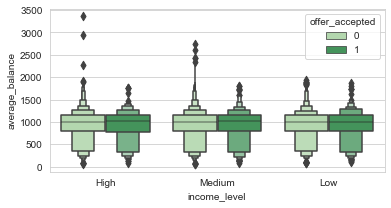

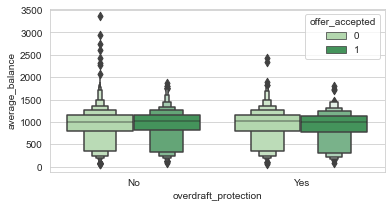

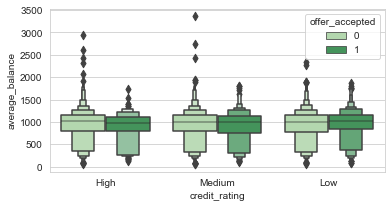

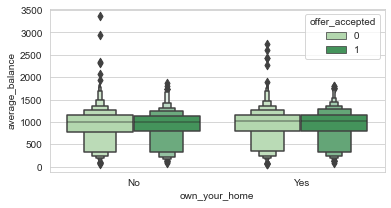

In [39]:
for column in categoricals:      
    plt.figure(figsize=(6,3))
    plt.ylabel('Amounts')
    sns.boxenplot(x=categoricals[column], y=continuous_df['average_balance'], hue=target['offer_accepted'], palette='Greens')
    plt.show()

### Observations
1. Distributions:
    - The income level follows a normal distribution
    - The variables with the most data imbalance are Offer Accepted and Overdraft Protection
 
<br>

2. `Yes` and `No` repartition:
    - There are more `Yes` with the Medium and Low Income Levels, possibly because the clients in the High Income level bracket already have enough credit cards.
    - There are more `Yes` with the clients who have no overdraft protection
    - The lowest the Credit Rating, the higher the number of `Yes`, although it is worth noting that this inverse correlation can be easily explained by the most common causes of a bad credit rating, namely, the failure to stick to one's credit agreement, and paying the bare minimum on your credit card each month. If a client doesn't have a credit card, then their risk of falling behind on their credit score is much lower.
    - More people accept a credit card offer if they own their home.
    
<br>

3. Outliers:
    - We systematically find more outliers with the `No` values. We can make the assumption that it is due to the more heterogenous nature of the data collected from the clients who answered `No` to the credit card offer.
    - We could also make the hypothesis that the clients who answered `Yes` to the credit card offer have enough in common to make the data we collected from them more homogenous, which would therefore reduce the number of outliers.   

# Preparing the Data for Modeling

## Preparing the numerical data

### Improving the distribution
We will try different methods to find out which works best by checking the distribution again, and once more after having removed the outliers.

###### Box-Cox
It will also get rid of some of the outliers

In [40]:
def remove_outliers(df, threshold=1.5):
    numerical = df.select_dtypes(np.number)
    columns = numerical.columns
    for column in columns:
        upper = np.percentile(df[column], 75)
        lower = np.percentile(df[column], 25)
        iqr = upper - lower
        upper_limit = upper + threshold * iqr
        lower_limit = lower - threshold * iqr
        no_outliers = df[(df[column]>lower_limit) & (df[column]<upper_limit)]
    print(round((100 - ((len(no_outliers)/len(df))*100)), 2), '% of outliers removed or ', len(df)-len(no_outliers), ' number of rows removed')
    return no_outliers

In [41]:
continuous_df_o = remove_outliers(continuous_df, threshold=1)

1.89 % of outliers removed or  339  number of rows removed


In [42]:
def boxcox_transform(data):
    numeric_cols = data.select_dtypes(np.number).columns
    _ci = {column: None for column in numeric_cols}
    for column in numeric_cols:
        data[column] = np.where(data[column]<=0, np.NAN, data[column]) 
        data[column] = data[column].fillna(data[column].mean())
        transformed_data, ci = stats.boxcox(data[column])
        data[column] = transformed_data
        _ci[column] = [ci] 
    return data, _ci

In [43]:
continuous_bc, _ci = boxcox_transform(continuous_df_o)
continuous_bc.head()

,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
1,10508.016408,76.189338,673.452795,166.244375,55.057104
2,639.429874,10.292356,88.729617,26.643233,33.189078
3,1502.931989,35.098500,281.191533,41.284094,26.848217
4,11229.043308,74.061374,1310.216869,168.720547,35.549671
5,11129.278028,86.364223,1022.035934,154.339480,33.142881


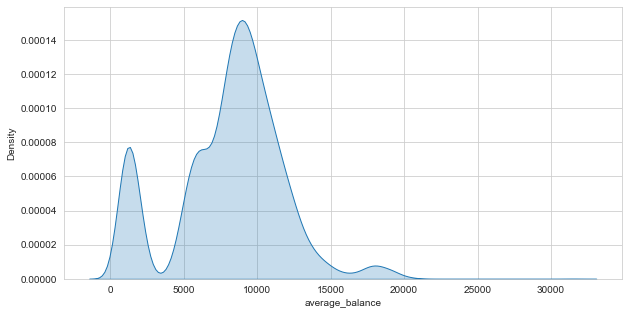

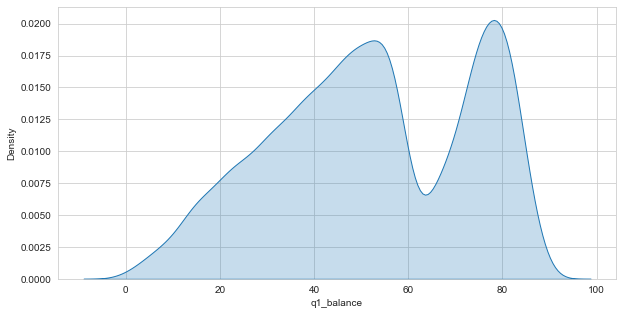

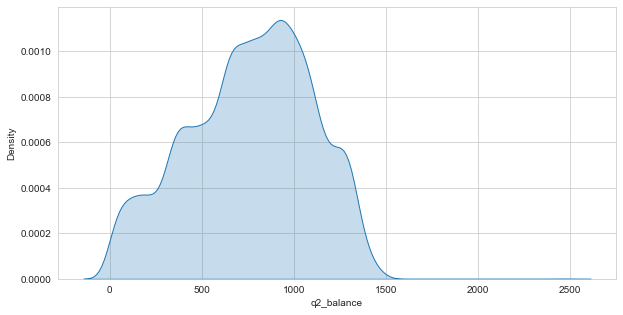

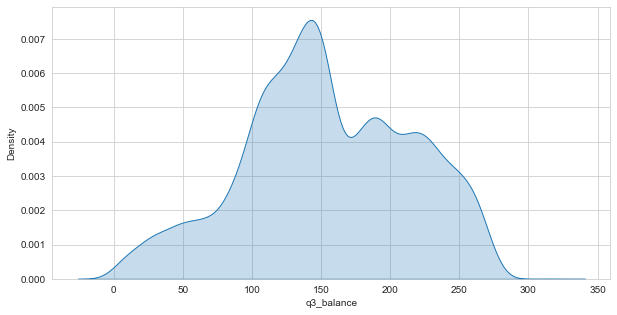

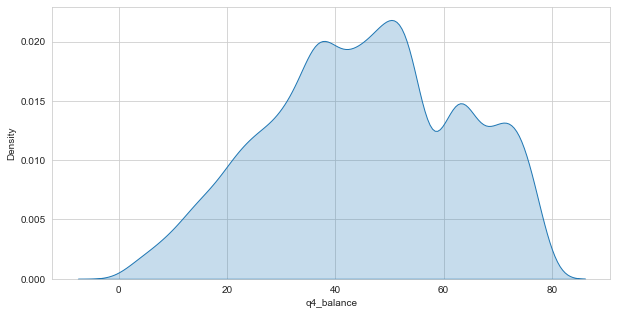

In [44]:
boxcox_dist = check_dist(continuous_bc)

###### Log

In [45]:
def log_transfom_clean_(x):
    if np.isfinite(x) and x!=0: # If the value is finite and != 0...
        return np.log(x)
    else:
        return np.NAN

In [46]:
def fix_dist(df, function):
    new_df = df.copy()
    for column in new_df:
        new_df[column] = list(map(function, new_df[column]))
        new_df[column] = new_df[column].fillna(new_df[column].median())
    return new_df

In [47]:
continuous_log = fix_dist(continuous_df, log_transfom_clean_)
continuous_log.head()

,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
1,7.056822,7.419980,6.776507,6.998510,6.909753
2,4.992132,3.663562,4.663439,4.356709,5.902633
3,5.622211,5.905362,5.863631,4.976734,5.488938
4,7.105786,7.363914,7.473069,7.020191,6.037871
5,7.099202,7.668561,7.213032,6.889591,5.899897


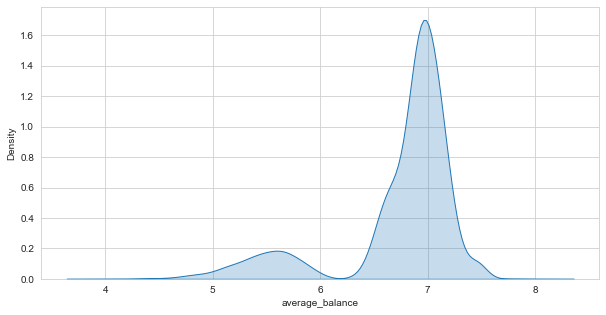

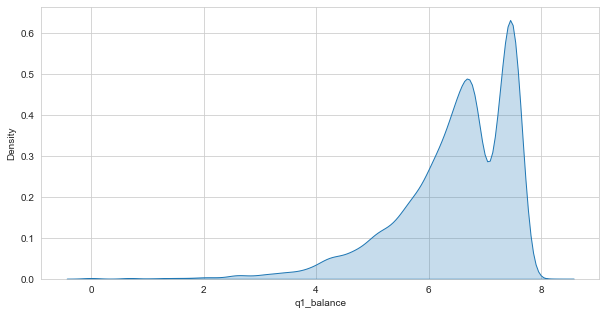

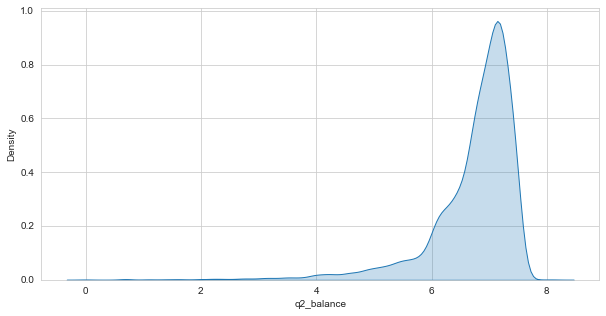

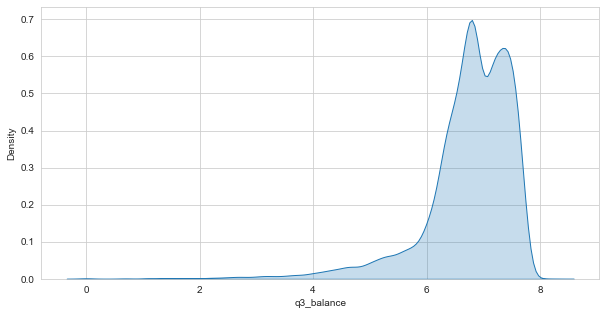

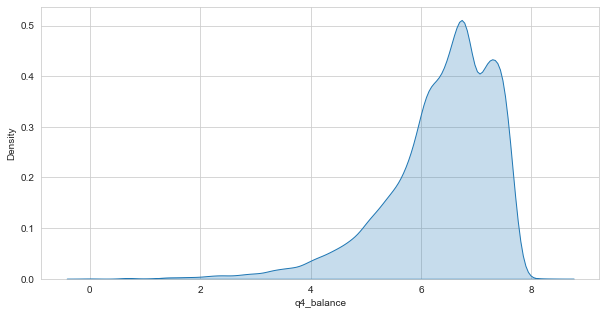

In [48]:
log_dist = check_dist(continuous_log)

###### Sqrt

In [49]:
def sqrt_transfom_clean_(x):
    if np.isfinite(x) and x>=0:
        return np.sqrt(x)
    else:
        return np.NAN

In [50]:
continuous_sqrt = fix_dist(continuous_df, sqrt_transfom_clean_)
continuous_sqrt.head()

,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
1,34.069781,40.853396,29.614186,33.090784,31.654384
2,12.134661,6.244998,10.295630,8.831761,19.131126
3,16.628289,19.157244,18.761663,12.041595,15.556349
4,34.914181,39.724048,41.952354,33.451457,20.469489
5,34.799425,46.260134,36.837481,31.336879,19.104973


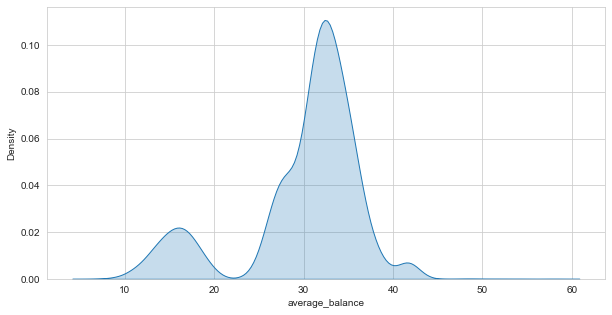

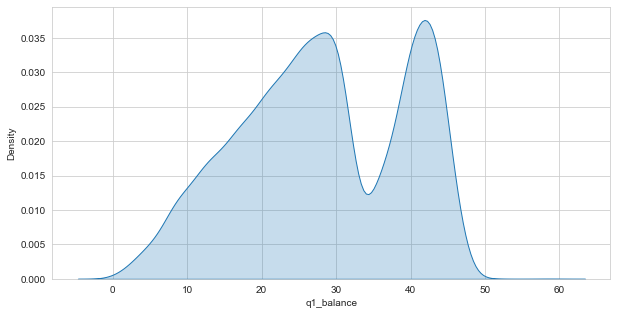

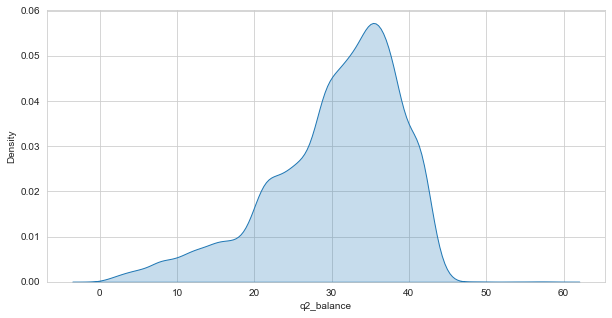

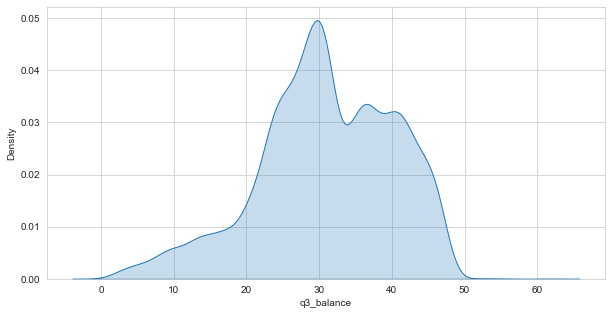

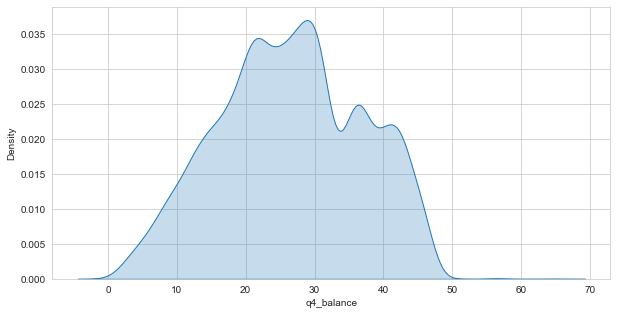

In [51]:
sqrt_dist = check_dist(continuous_sqrt)

#### Observations
It seems like the sqrt transformation has yielded the best results. We still need to check the results after having removed the outliers.

### Removing the outliers

In [52]:
def remove_outliers(df, threshold=1.5):
    numerical = df.select_dtypes(np.number)
    columns = numerical.columns
    for column in columns:
        if len(df[column].unique()) < 10:
            continue
        else:
            upper = np.percentile(df[column], 75)
            lower = np.percentile(df[column], 25)
            iqr = upper - lower
            upper_limit = upper + threshold * iqr
            lower_limit = lower - threshold * iqr
            no_outliers = df[(df[column]>lower_limit) & (df[column]<upper_limit)]
    print(round((100 - ((len(no_outliers)/len(df))*100)), 2), '% of outliers removed')
    return no_outliers

In [53]:
continuous_bc_2 = remove_outliers(continuous_bc, threshold=1.5)
continuous_log_2 = remove_outliers(continuous_log, threshold=1.5)
continuous_sqrt_2 = remove_outliers(continuous_sqrt, threshold=1.5)

0.0 % of outliers removed
3.37 % of outliers removed
0.01 % of outliers removed


##### We have a lot of observations and outliers are few, so we can afford to drop the outliers.

### Let's check the distributions again

#### Density plots

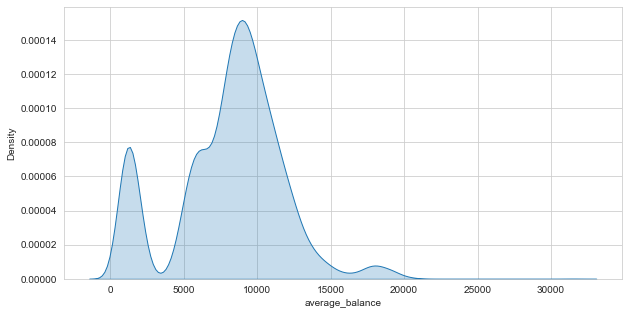

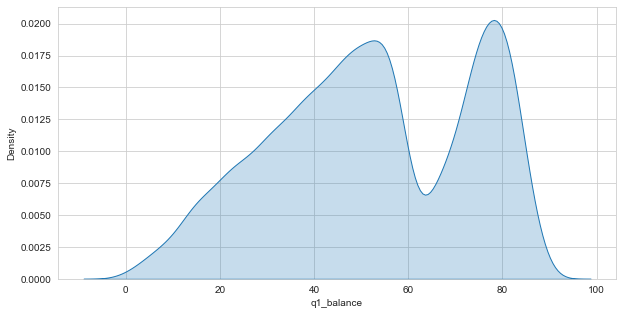

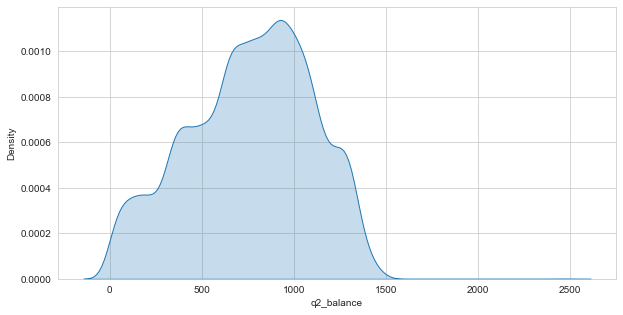

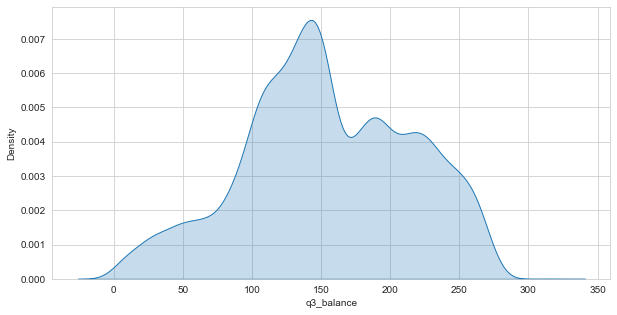

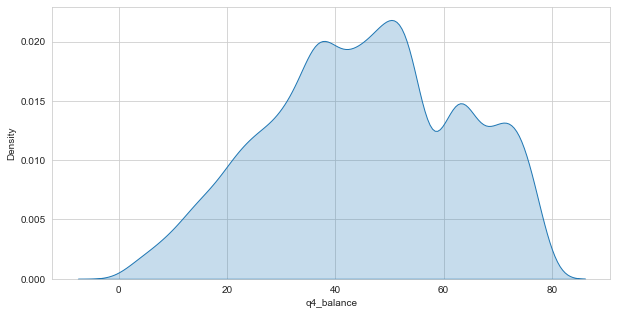

In [54]:
bc_dist_2 = check_dist(continuous_bc_2)

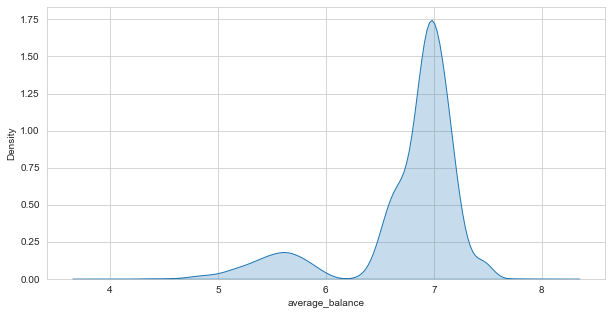

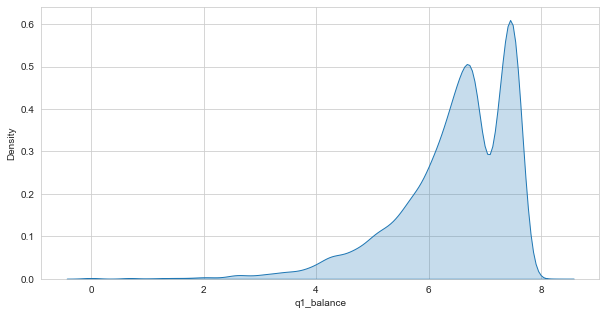

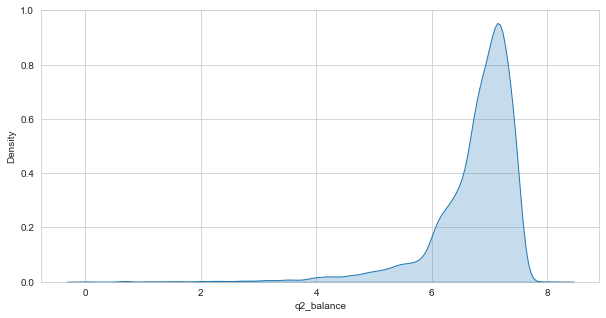

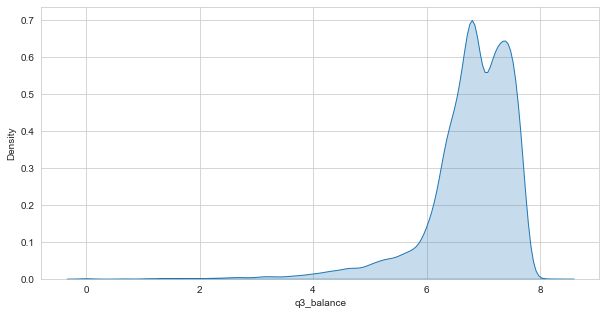

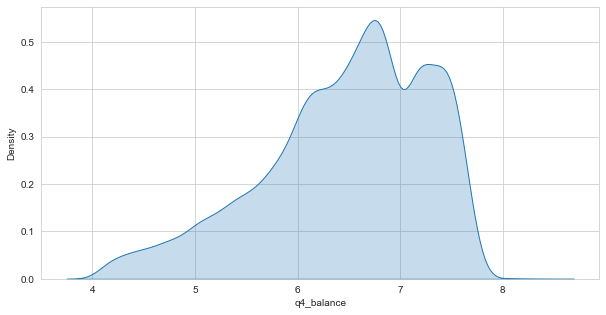

In [55]:
log_dist_2 = check_dist(continuous_log_2)

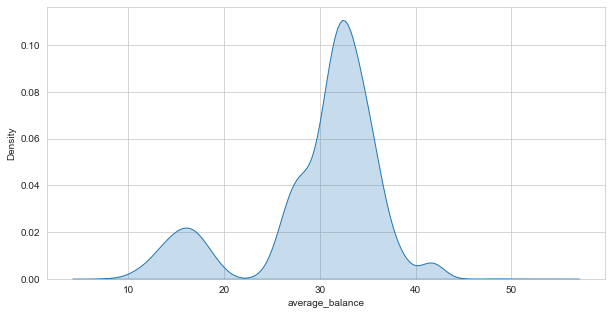

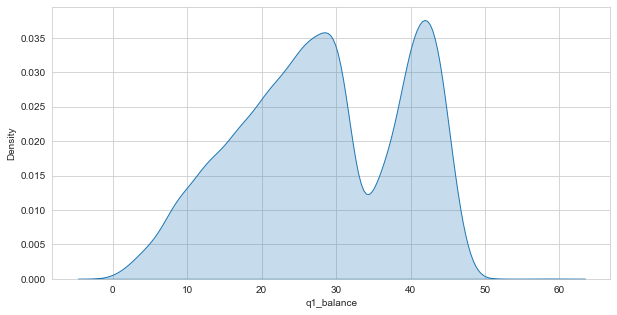

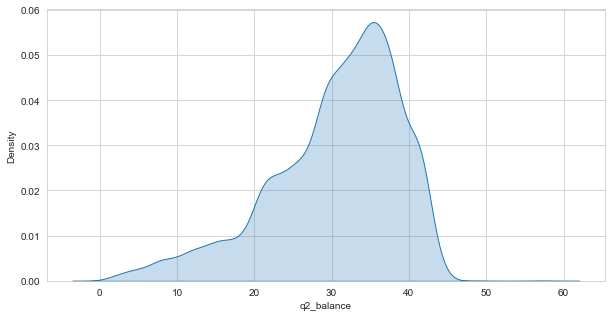

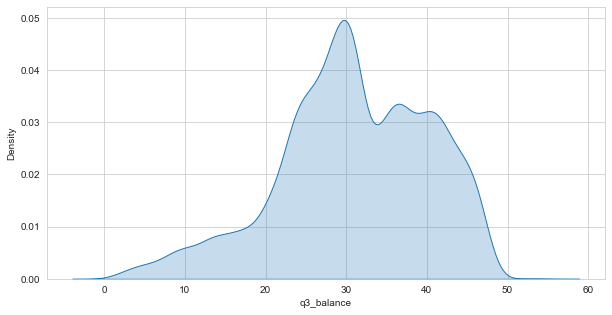

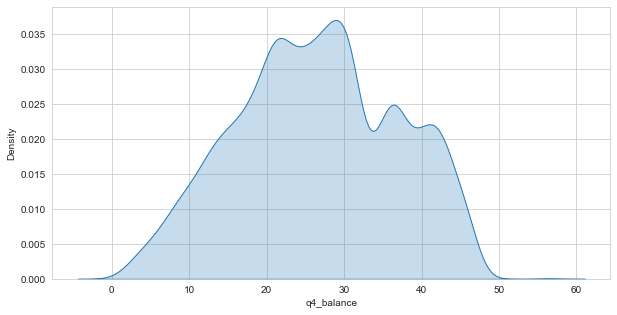

In [56]:
sqrt_dist_2 = check_dist(continuous_sqrt_2)

#### Visualizing the change in outliers

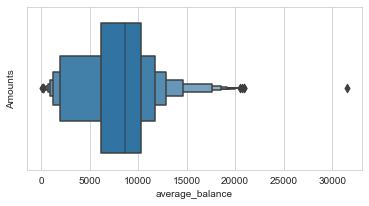

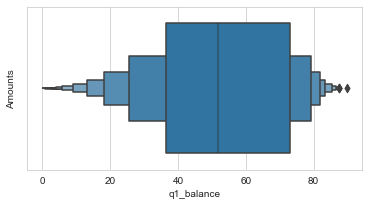

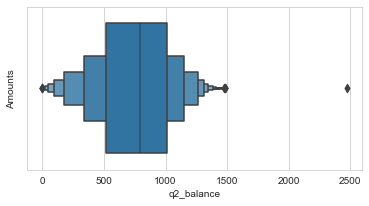

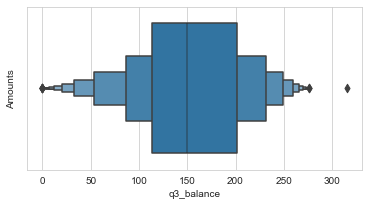

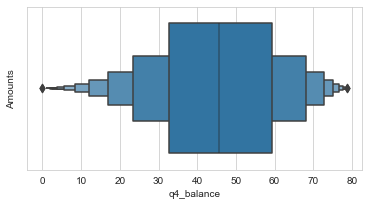

In [57]:
for column in continuous_bc:      
    plt.figure(figsize=(6,3))
    plt.ylabel('Amounts')
    sns.boxenplot(x=continuous_bc[column])
    plt.show()

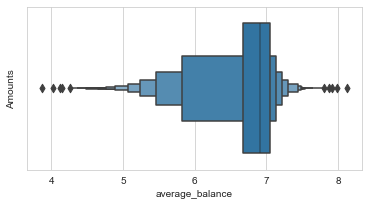

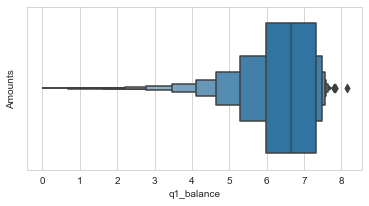

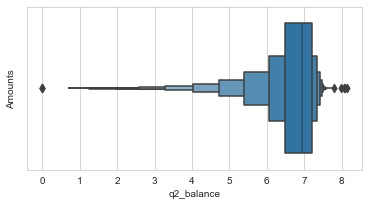

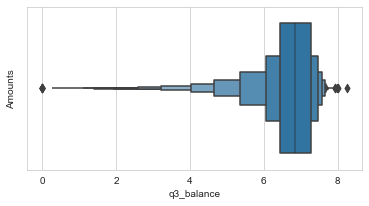

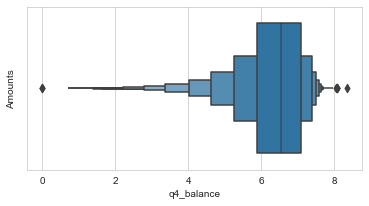

In [58]:
for column in continuous_log:      
    plt.figure(figsize=(6,3))
    plt.ylabel('Amounts')
    sns.boxenplot(x=continuous_log[column])
    plt.show()

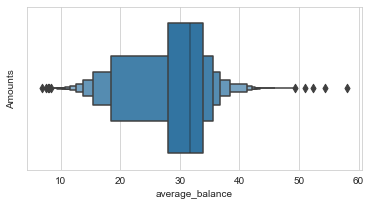

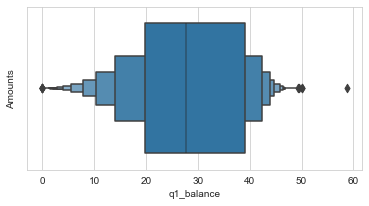

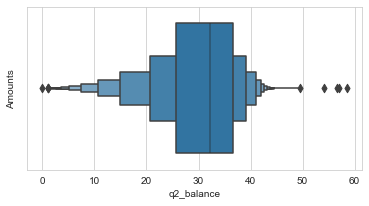

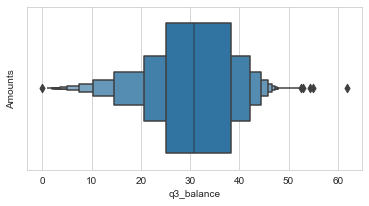

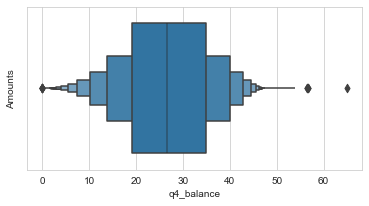

In [59]:
for column in continuous_sqrt:      
    plt.figure(figsize=(6,3))
    plt.ylabel('Amounts')
    sns.boxenplot(x=continuous_sqrt[column])
    plt.show()

#### Assessment:
The distribution with the sqrt transformation is still slightly better than the two others, but the boxcox already takes care of a significant amount of outliers which means we don't have to remove them. Thus, we lose less data.
So we will continue with the data transformed by the BoxCox.

### Scaling the data using Standard Scaler
Min-Max generates smaller standard deviations which means the data is concentrated around the mean. \
As a result it doesn't handle outliers well. \
The Standard Scaler normalization method is often more robust to datasets that contain outliers.

In [60]:
def standard_scaling(df):
    transformer = StandardScaler().fit(df)
    x_standardized = transformer.transform(df)
    X = pd.DataFrame(x_standardized)
    X.columns = df.columns
    return X

In [61]:
scaled_numericals = standard_scaling(continuous_bc)
scaled_numericals.head()

,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
0,0.639244,1.136345,-0.256322,0.197884,0.551518
1,-2.005642,-1.970896,-1.990242,-2.093255,-0.684183
2,-1.774214,-0.801211,-1.419521,-1.852968,-1.042488
3,0.832487,1.036005,1.631919,0.238523,-0.550793
4,0.805749,1.616122,0.777356,0.002500,-0.686794


## Preparing the categorical data

### Encoding the nominal categorical data

Nominal categorical variables:
   - reward 
   - mailer_type 
   - overdraft_protection 
   - own_your_home    

We will also drop the target from the categorical dataframe.

In [62]:
categoricals = categoricals.drop(['offer_accepted'], axis=1)
categoricals.head()

,reward,mailer_type,income_level,overdraft_protection,credit_rating,own_your_home
customer_number,,,,,,
1,Air Miles,Letter,High,No,High,No
2,Air Miles,Letter,Medium,No,Medium,Yes
3,Air Miles,Postcard,High,No,Medium,Yes
4,Air Miles,Letter,Medium,No,High,No
5,Air Miles,Letter,Medium,No,Medium,Yes


In [63]:
def encode_nom(df, column_names = []):
    encoder = OneHotEncoder(handle_unknown='error').fit(df[column_names])
    encoded = encoder.transform(df[column_names]).toarray()
    encoded_df = pd.DataFrame(encoded)
    encoded_df.columns = encoder.get_feature_names()
    return encoded_df

In [64]:
nominal = encode_nom(categoricals, column_names = ['reward', 'mailer_type', 'overdraft_protection', 'own_your_home'])
nominal.columns = nominal.columns.str.replace(" ", "_").str.lower().str.replace('x0', 'reward').str.replace('x1', 'mailer_type').str.replace('x2', 'overdraft_protection').str.replace('x3', 'own_your_home')
nominal.head()

,reward_air_miles,reward_cash_back,reward_points,mailer_type_letter,mailer_type_postcard,overdraft_protection_no,overdraft_protection_yes,own_your_home_no,own_your_home_yes
0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


### Encoding the ordinal categorical data

Ordinal variables:
   - income_level
   - credit_rating

In [65]:
ordinal = categoricals[['income_level','credit_rating']]

# We will rank it from Low to High:
income_dict = {'Low':0,
            'Medium':1,
            'High':2}

credit_dict = {'Low':0,
            'Medium':1,
            'High':2}

# Create the mapped values in a new column
ordinal['income_level'] = ordinal['income_level'].map(income_dict)
ordinal['credit_rating'] = ordinal['credit_rating'].map(credit_dict)

# Check
ordinal.head()


,income_level,credit_rating
customer_number,,
1,2,2
2,1,1
3,2,1
4,1,2
5,1,1


### Re-assembling our data before modeling

##### Let's first do a final check of the length

In [66]:
print(len(target),', ', len(ordinal),', ', len(nominal),', ', len(scaled_numericals),', ',len(ordinal)-len(scaled_numericals))

17976 ,  17976 ,  17976 ,  17637 ,  339


In [69]:
ordinal.reset_index(drop=True, inplace=True)
nominal.reset_index(drop=True, inplace=True)
scaled_numericals.reset_index(drop=True, inplace=True)
target.reset_index(drop=True, inplace=True)

cat = pd.concat([ordinal, nominal], axis=1)
X = pd.merge(scaled_numericals, cat, how='left', left_index=True, right_index=True)
final_data = pd.merge(X, target, how='left', left_index=True, right_index=True)
final_data.head()

,average_balance,q1_balance,q2_balance,q3_balance,q4_balance,income_level,credit_rating,reward_air_miles,reward_cash_back,reward_points,mailer_type_letter,mailer_type_postcard,overdraft_protection_no,overdraft_protection_yes,own_your_home_no,own_your_home_yes,offer_accepted
0,0.639244,1.136345,-0.256322,0.197884,0.551518,2,2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0
1,-2.005642,-1.970896,-1.990242,-2.093255,-0.684183,1,1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0
2,-1.774214,-0.801211,-1.419521,-1.852968,-1.042488,2,1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0
3,0.832487,1.036005,1.631919,0.238523,-0.550793,1,2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0
4,0.805749,1.616122,0.777356,0.002500,-0.686794,1,1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0


# Modeling
We will train and test different models to figure out which performs best: 
   1. Logistic Regression
   2. KNN Classifier

### Splitting the target

In [70]:
y = final_data['offer_accepted']
X = X.drop(['income_level', 'reward_air_miles', 'reward_cash_back', 'reward_points', 'mailer_type_letter', 'mailer_type_postcard', 'overdraft_protection_no', 'overdraft_protection_yes', 'own_your_home_no', 'own_your_home_yes'], axis=1)
X

,average_balance,q1_balance,q2_balance,q3_balance,q4_balance,credit_rating
0,0.639244,1.136345,-0.256322,0.197884,0.551518,2
1,-2.005642,-1.970896,-1.990242,-2.093255,-0.684183,1
2,-1.774214,-0.801211,-1.419521,-1.852968,-1.042488,1
3,0.832487,1.036005,1.631919,0.238523,-0.550793,2
4,0.805749,1.616122,0.777356,0.002500,-0.686794,1
...,...,...,...,...,...,...
17632,-1.972905,-1.477670,-2.089531,-2.121678,-0.602530,1
17633,-0.329422,0.292130,-0.119416,-0.066602,-0.286688,2
17634,0.400298,0.196629,-0.496464,0.323955,1.232370,0
17635,0.193705,-0.275220,-0.026214,-0.207657,1.380964,1


### Train-Test, Modeling, Accuracy, Scores and graph functions

In [71]:
def modeling(y, X, models=[], test_size=0.3):
    for model in models:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        model.fit(X_train, y_train )
        y_pred_class = model.predict(X_test)
        model_count = pd.Series(y_pred_class).value_counts()
        data_count = y_test.value_counts()
        matrix = confusion_matrix(y_test, y_pred_class)
        print(model, ': ')
        print(model_count, '\n')
        print('The data count is: ', data_count, '\n')
        print('The matrix is: ', matrix)
        print('\n')
    return model, y_pred_class, y_test, X_test

def model_accuracy(y_test, y_pred_class):
    confusion = confusion_matrix(y_test, y_pred_class)
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    print("Classifier accuracy is: ", round((TP + TN) / float(TP + TN + FP + FN), 2))
    sensitivity = round(TP / float(FN + TP), 2)
    print("The model sensitivity is: ", sensitivity)
    false_negative_rate = round(FN / float( FN + TP), 2)
    print("The model's false negative rate is: ", false_negative_rate)
    specificity = round(TN / (TN + FP), 2)
    print("The model specificity is: ", specificity)
    false_positive_rate = round(FP / float(TN + FP), 2)
    print("The model's false_positive_rate is: ", false_positive_rate)
    return confusion

def matrix_graph(confusion):
    graph = sns.heatmap(confusion, annot=True,fmt='g')
    return graph

def model_scores(model, X_test, y_test, y_pred_class):
    score = model.score(X_test, y_test)
    report = classification_report(y_test, y_pred_class)
    print('The model score is: ', round(model.score(X_test, y_test),4), '\n')
    print('The report is: \n', classification_report(y_test, y_pred_class))
    return score, report

def roc_graph(y_test, X_test, model):
    logit_roc_auc = metrics.roc_auc_score(y_test, model.predict(X_test))
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return graph

def diff_df(y_test, y_pred_class):
    results = pd.DataFrame()
    results['true'] = y_test
    results['pred'] = y_pred_class
    results['difference'] = results.apply(lambda x: 'true'if (x['true'] == x['pred']) else 'false', axis=1)
    results = results.sort_values('difference', ascending=True)
    return results

## Logistic Regression

In [72]:
model, y_pred_class, y_test, X_test = modeling(y, X, models = [LogisticRegression(multi_class='auto')], test_size=0.3)

LogisticRegression() : 
0    5292
dtype: int64 

The data count is:  0    5000
1     292
Name: offer_accepted, dtype: int64 

The matrix is:  [[5000    0]
 [ 292    0]]




In [73]:
confusion = model_accuracy(y_test, y_pred_class)

Classifier accuracy is:  0.94
The model sensitivity is:  0.0
The model's false negative rate is:  1.0
The model specificity is:  1.0
The model's false_positive_rate is:  0.0


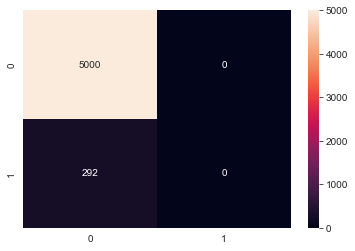

In [74]:
graph = matrix_graph(confusion)

In [75]:
score, report = model_scores(model, X_test, y_test, y_pred_class)

The model score is:  0.9448 

The report is: 
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      5000
           1       0.00      0.00      0.00       292

    accuracy                           0.94      5292
   macro avg       0.47      0.50      0.49      5292
weighted avg       0.89      0.94      0.92      5292



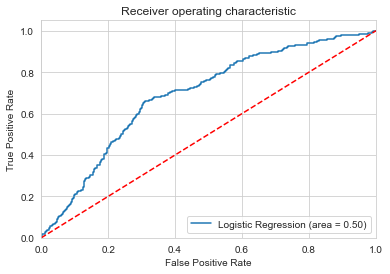

In [76]:
roc_curve = roc_graph(y_test, X_test, model)

#### It seems that due to data imblance the model is very bad at predicting `Yes`
Even though the classifier accuracy is very good, it doesn't mean anything as we're just very good at predicting `No` as we only predict `No`.

We will improve the model's sensitivity by reducing the data imbalance.

## Reducing Data Imbalance

### Using SMOTE

In [77]:
def smote_modeling(X, y, models = [], test_size=0.3):
    os = SMOTE(random_state=0)
    X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X, y, test_size=test_size, random_state=42)
    columns = X_smote_train.columns
    os_data_X,os_data_y=os.fit_sample(X_smote_train, y_smote_train)
    os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
    os_data_y = pd.DataFrame(data=os_data_y,columns=['offer_accepted'])
    y_smote = os_data_y['offer_accepted']
    print("length of oversampled data is ",len(os_data_X))
    print("Number of No in oversampled data",len(os_data_y[os_data_y['offer_accepted']==0]))
    print("Number of Yes",len(os_data_y[os_data_y['offer_accepted']==1]))
    print("Proportion of No in oversampled data is ",len(os_data_y[os_data_y['offer_accepted']==0])/len(os_data_X))
    print("Proportion of Yes data in oversampled data is ",len(os_data_y[os_data_y['offer_accepted']==1])/len(os_data_X))
    print('\n')
    for model in models:
        smodel = model.fit(os_data_X, os_data_y )
        y_smote_pred_class = smodel.predict(X_smote_test)
        smodel_count = pd.Series(y_smote_pred_class).value_counts()
        smote_data_count = y_smote_test.value_counts()
        smote_matrix = confusion_matrix(y_smote_test, y_smote_pred_class)
        print(smodel, 'is: \n')
        print('model count is:')
        print(smodel_count)
        print('\n')
        print('data count is:')
        print(smote_data_count)
        print('\n')
        print('matrix is:')
        print(smote_matrix)
        print('\n')
    return os_data_X, os_data_y, y_smote, smodel, X_smote_test, y_smote_test, y_smote_pred_class

### Running and evaluating the model after the imbalance reduction with SMOTE

In [78]:
os_data_X, os_data_y, y_smote, smodel, X_smote_test, y_smote_test, y_smote_pred_class = smote_modeling(X, y, models = [LogisticRegression(multi_class='auto')], test_size=0.3)

length of oversampled data is  23286
Number of No in oversampled data 11643
Number of Yes 11643
Proportion of No in oversampled data is  0.5
Proportion of Yes data in oversampled data is  0.5


LogisticRegression() is: 

model count is:
0    3550
1    1742
dtype: int64


data count is:
0    5000
1     292
Name: offer_accepted, dtype: int64


matrix is:
[[3450 1550]
 [ 100  192]]




In [79]:
smote_confusion = model_accuracy(y_smote_test, y_smote_pred_class)

Classifier accuracy is:  0.69
The model sensitivity is:  0.66
The model's false negative rate is:  0.34
The model specificity is:  0.69
The model's false_positive_rate is:  0.31


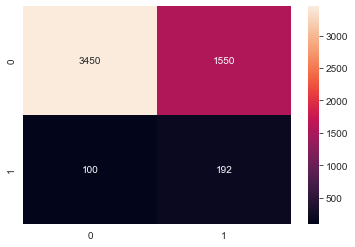

In [80]:
smote_graph = matrix_graph(smote_confusion)

In [81]:
smote_score, smote_report = model_scores(smodel, X_smote_test, y_smote_test, y_smote_pred_class)

The model score is:  0.6882 

The report is: 
               precision    recall  f1-score   support

           0       0.97      0.69      0.81      5000
           1       0.11      0.66      0.19       292

    accuracy                           0.69      5292
   macro avg       0.54      0.67      0.50      5292
weighted avg       0.92      0.69      0.77      5292



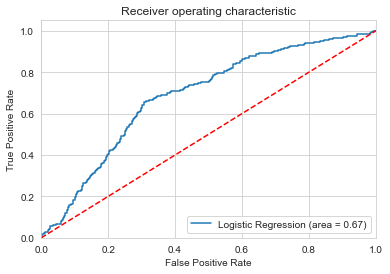

In [82]:
smote_roc_curve = roc_graph(y_smote_test, X_smote_test, smodel)

In [83]:
results_logreg = diff_df(y_smote_test, y_smote_pred_class)
results_logreg

,true,pred,difference
15461,0,1,false
13702,0,1,false
1639,0,1,false
9546,0,1,false
17549,0,1,false
...,...,...,...
5464,0,0,true
2878,0,0,true
7316,0,0,true
5224,0,0,true


In [84]:
round(results_logreg.difference.value_counts(normalize=True)*100,2)

true     68.82
false    31.18
Name: difference, dtype: float64

### Observations:
The sensitiviy of the model has greatly improved, we are much better at predicting `Yes` values. \
It's also with the SMOTE method that the recall metric for the 1 class is the highest, 0.70.

## KNN Classifier

In [85]:
k_model, k_y_pred_class, k_y_test, k_X_test = modeling(y, X, models = [KNeighborsClassifier(n_neighbors = 28)], test_size=0.3)

KNeighborsClassifier(n_neighbors=28) : 
0    5292
dtype: int64 

The data count is:  0    5000
1     292
Name: offer_accepted, dtype: int64 

The matrix is:  [[5000    0]
 [ 292    0]]




In [86]:
konfusion = model_accuracy(k_y_test, k_y_pred_class)

Classifier accuracy is:  0.94
The model sensitivity is:  0.0
The model's false negative rate is:  1.0
The model specificity is:  1.0
The model's false_positive_rate is:  0.0


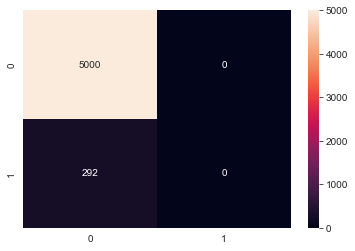

In [87]:
kraph = matrix_graph(konfusion)

In [88]:
skore, kreport = model_scores(k_model, k_X_test, k_y_test, k_y_pred_class)

The model score is:  0.9448 

The report is: 
               precision    recall  f1-score   support

           0       0.94      1.00      0.97      5000
           1       0.00      0.00      0.00       292

    accuracy                           0.94      5292
   macro avg       0.47      0.50      0.49      5292
weighted avg       0.89      0.94      0.92      5292



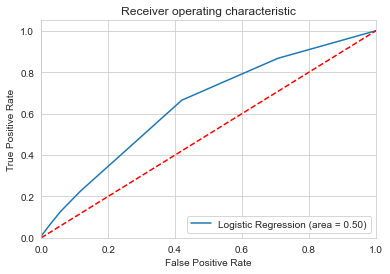

In [89]:
roc_kurve = roc_graph(k_y_test, k_X_test, k_model)

### KNN Classifier performance after reducing the data imbalance with SMOTE

In [90]:
kos_data_X, kos_data_y, k_y_smote, k_smodel, k_X_smote_test, k_y_smote_test, k_y_smote_pred_class = smote_modeling(X, y, models = [KNeighborsClassifier(n_neighbors = 28)], test_size=0.3)

length of oversampled data is  23286
Number of No in oversampled data 11643
Number of Yes 11643
Proportion of No in oversampled data is  0.5
Proportion of Yes data in oversampled data is  0.5


KNeighborsClassifier(n_neighbors=28) is: 

model count is:
0    3362
1    1930
dtype: int64


data count is:
0    5000
1     292
Name: offer_accepted, dtype: int64


matrix is:
[[3223 1777]
 [ 139  153]]




In [91]:
konfuSsion = model_accuracy(k_y_smote_test, k_y_smote_pred_class)

Classifier accuracy is:  0.64
The model sensitivity is:  0.52
The model's false negative rate is:  0.48
The model specificity is:  0.64
The model's false_positive_rate is:  0.36


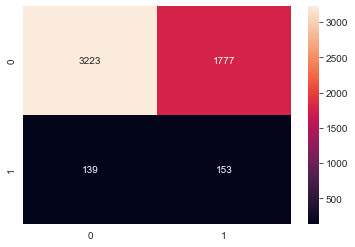

In [92]:
k_smote_graph = matrix_graph(konfuSsion)

In [93]:
smote_skore, smote_kreport = model_scores(k_smodel, k_X_smote_test, k_y_smote_test, k_y_smote_pred_class)

The model score is:  0.6379 

The report is: 
               precision    recall  f1-score   support

           0       0.96      0.64      0.77      5000
           1       0.08      0.52      0.14       292

    accuracy                           0.64      5292
   macro avg       0.52      0.58      0.45      5292
weighted avg       0.91      0.64      0.74      5292



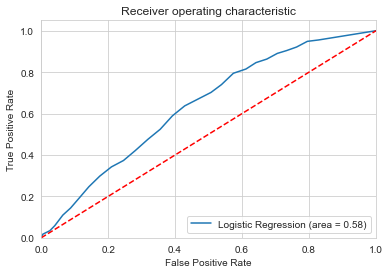

In [94]:
smote_roc_kurve = roc_graph(k_y_smote_test, k_X_smote_test, k_smodel)

In [95]:
results_knn = diff_df(k_y_smote_test, k_y_smote_pred_class)
results_knn

,true,pred,difference
15461,0,1,false
4333,0,1,false
12961,0,1,false
11909,0,1,false
829,0,1,false
...,...,...,...
13594,0,0,true
2006,0,0,true
1288,0,0,true
7337,0,0,true


In [96]:
round(results_knn.difference.value_counts(normalize=True)*100,3)

true     63.794
false    36.206
Name: difference, dtype: float64

### Finding the best k-value

#### Minimum error plot

Minimum error:  0.16194255479969766 at K = 1


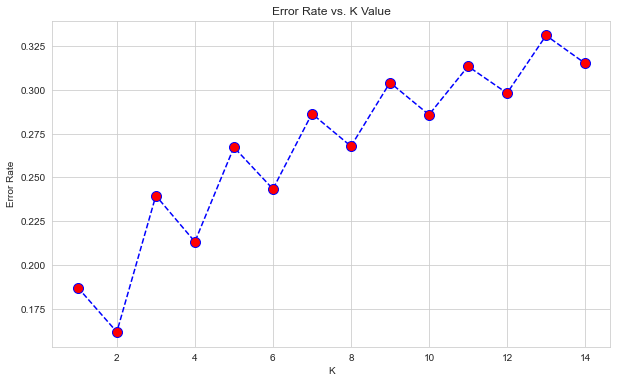

In [97]:
error_rate = []

for i in range(1,15):
    classifier = KNeighborsClassifier(n_neighbors=i)
    classifier.fit(kos_data_X,kos_data_y)
    pred_i = classifier.predict(k_X_smote_test)
    error_rate.append(np.mean(pred_i != k_y_smote_test))

# plotting the error rate
plt.figure(figsize=(10,6))
plt.plot(range(1,15),error_rate,color='blue', linestyle='dashed', marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error: ",min(error_rate),"at K =",error_rate.index(min(error_rate)))

#### Accuracy plot

Maximum accuracy:  0.8380574452003023 at K = 1


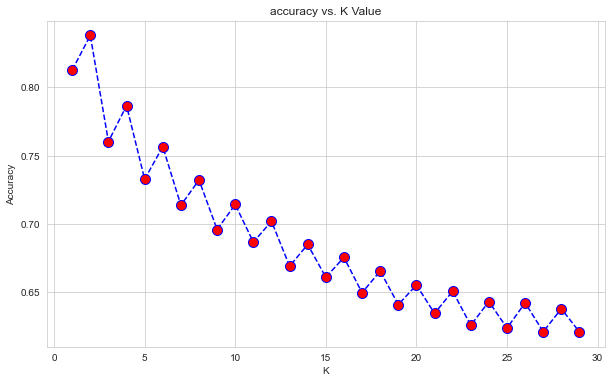

In [98]:
acc = []

for i in range(1,30):
    knn = KNeighborsClassifier(n_neighbors = i).fit(kos_data_X,kos_data_y)
    y_acc = knn.predict(k_X_smote_test)
    acc.append(metrics.accuracy_score(k_y_smote_test, y_acc))

# plotting the accuracy score
plt.figure(figsize=(10,6))
plt.plot(range(1,30),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy: ",max(acc),"at K =",acc.index(max(acc)))

#### False negative plot

Minimum false negative rate:  0.44 at K = 28


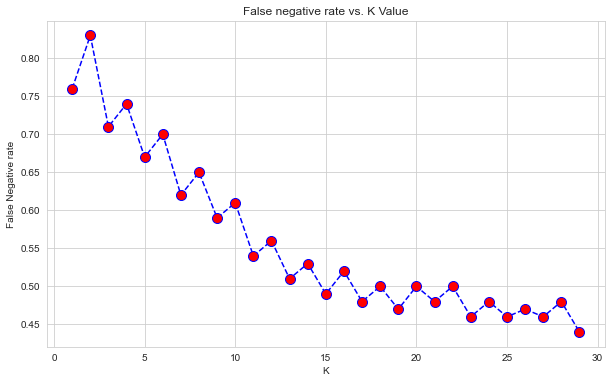

In [99]:
FNR = []

for i in range(1,30):
    knn = KNeighborsClassifier(n_neighbors = i).fit(kos_data_X,kos_data_y)
    y_FN = knn.predict(k_X_smote_test)
    conf = confusion_matrix(k_y_smote_test, y_FN)
    TP = conf[1, 1]
    TN = conf[0, 0]
    FP = conf[0, 1]
    FN = conf[1, 0]
    false_negative_rate = round(FN / int( FN + TP), 2)
    FNR.append(false_negative_rate)

# plotting the false negative rate
plt.figure(figsize=(10,6))
plt.plot(range(1,30),FNR,color = 'blue',linestyle='dashed', marker='o',markerfacecolor='red', markersize=10)
plt.title('False negative rate vs. K Value')
plt.xlabel('K')
plt.ylabel('False Negative rate')
print("Minimum false negative rate: ", min(FNR),"at K =",FNR.index(min(FNR)))

##### Observations on the best k value
Lowest FN rate is actually at K = 52 but there is very little difference in FN rate compared to k = 28 and it is much more expensive so we will stick to k = 28.

### Observations about outliers
Changing the threshold to exclude more outliers (from 1.5 to 1 threshold) changes very little (only -0.01 for the area under the ROC curve.
Same for replacing the NaNs with the mean instead of the median when applying the BoxCox transformation.

To try: KNN, interpolation

### 2. F1 Score
In the last section, we discussed precision and recall for classification problems and also highlighted the importance of choosing precision/recall basis our use case. What if for a use case, we are trying to get the best precision and recall at the same time? F1-Score is the harmonic mean of precision and recall values for a classification problem. The formula for F1-Score is as follows:


### Undersampling using Tomek Links

In [140]:
def tomek_modeling(y, X, models=[], test_size=0.3):
    for model in models:
        X_train_tl, X_test_tl, y_train_tl, y_test_tl = train_test_split(X, y, test_size=test_size, random_state=42)
        undersample = TomekLinks("majority")
        X_train_tl, y_train_tl = undersample.fit_resample(X_train_tl, y_train_tl)
        tl_model = model.fit(X_train_tl, y_train_tl)
        y_tl_pred_class = tl_model.predict(X_test_tl)
        tl_model_count = pd.Series(y_tl_pred_class).value_counts()
        tl_data_count = y_test_tl.value_counts()
        tl_matrix = confusion_matrix(y_test_tl, y_tl_pred_class)
        print(tl_model_count)
        print(tl_data_count)
        print(tl_matrix)
    return tl_model, y_tl_pred_class, y_test_tl, X_test_tl

In [141]:
tl_model, y_tl_pred_class, y_test_tl, X_test_tl = tomek_modeling(y, X, models=[LogisticRegression(multi_class='auto')], test_size=0.3)

0    5393
dtype: int64
0    5083
1     310
Name: offer_accepted, dtype: int64
[[5083    0]
 [ 310    0]]
